In [ ]:
import json
import time
import ollama
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(0))

In [ ]:
# Define the prisoner's dilemma prompt separately for clarity
PRISONER_DILEMMA_PROMPT = """
You are facing a prisoner's dilemma:
- If both you and your partner stay silent, you each receive a short sentence.
- If you implicate your partner and they stay silent, you go free, and they receive a long sentence.
- If you stay silent while they implicate you, you receive a long sentence, and they go free.
- If you both implicate each other, you both receive a medium sentence.

What would you do? Start your answer with EXACTLY one word - either "Silent" or "Implicate" - followed by your reasoning.
"""

In [48]:
def parse_ollama_response_simple(response_text):
    """
    Simple and clean parser to extract decision and reason from Ollama response
    """
    if not response_text or len(response_text.strip()) == 0:
        return {
            "error": "Empty response",
            "response_text": "",
            "decision": None,
            "reason": None,
            "response": None
        }

    # First, check the first line for a clear decision
    first_line = response_text.strip().split('\n')[0].strip().lower()

    # Simple decision based on first line
    if "silent" in first_line:
        decision = "Silent"
        is_silent = True
    elif "implicate" in first_line:
        decision = "Implicate"
        is_silent = False
    else:
        # If decision isn't clear in first line, check entire text
        if "silent" in response_text.lower() and "implicate" not in response_text.lower():
            decision = "Silent"
            is_silent = True
        elif "implicate" in response_text.lower() and "silent" not in response_text.lower():
            decision = "Implicate"
            is_silent = False
        else:
            # If both or neither appear, just check first occurrence
            silent_pos = response_text.lower().find("silent")
            implicate_pos = response_text.lower().find("implicate")

            if silent_pos >= 0 and (implicate_pos < 0 or silent_pos < implicate_pos):
                decision = "Silent"
                is_silent = True
            else:
                decision = "Implicate"
                is_silent = False

    # Extract reason - everything after the first line
    parts = response_text.split('\n', 1)
    if len(parts) > 1:
        reason = parts[1].strip()
    else:
        # If no newline, try to separate the first word from the rest
        parts = response_text.strip().split(' ', 1)
        if len(parts) > 1:
            reason = parts[1].strip()
        else:
            reason = ""

    return {
        "response_text": response_text,
        "decision": decision,
        "reason": reason,
        "response": is_silent
    }

In [49]:
def get_ollama_response_clean(iteration):
    """Get response from Ollama with simple parsing"""
    try:
        start_time = time.time()

        # Use generate API with the separately defined prompt
        response = ollama.generate(
            model="llama3.2:latest",
            prompt=PRISONER_DILEMMA_PROMPT,
            options={"temperature": 0.7}
        )

        end_time = time.time()
        response_text = response['response']

        # Parse with simplified function
        parsed_result = parse_ollama_response_simple(response_text)

        # Combine parsed result with metadata
        result = {
            **parsed_result,  # Merge the parsed fields
            "iteration": iteration,
            "response_time": end_time - start_time,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        return result

    except Exception as e:
        return {
            "iteration": iteration,
            "error": str(e),
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

In [50]:
def run_simple_experiment(iterations=10):
    """Run the experiment with clean, simple code"""
    # Create output directory
    output_dir = "experiment_results"
    os.makedirs(output_dir, exist_ok=True)
    output_prefix = f"{output_dir}/prisoner_dilemma_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    # Storage for results
    full_results = []

    print(f"Running {iterations} iterations with llama3.2:latest...")
    for i in tqdm(range(1, iterations+1)):
        result = get_ollama_response_clean(i)
        full_results.append(result)
        time.sleep(1)  # Prevent rate limiting

    # Save full results (including errors and all metadata)
    full_output_file = f"{output_prefix}_full_results.json"
    with open(full_output_file, 'w') as f:
        json.dump(full_results, f, indent=2)

    print(f"\nExperiment completed.")
    print(f"Full results saved to: {full_output_file}")

    # Get valid results for statistics and final output
    valid_results = [r for r in full_results if "response" in r and r["response"] is not None]

    # Calculate statistics
    if valid_results:
        silent_count = sum(1 for r in valid_results if r["response"])
        implicate_count = len(valid_results) - silent_count

        print(f"\nStatistics:")
        print(f"Total valid responses: {len(valid_results)}")
        print(f"Silent decisions: {silent_count} ({silent_count/len(valid_results)*100:.1f}%)")
        print(f"Implicate decisions: {implicate_count} ({implicate_count/len(valid_results)*100:.1f}%)")
    else:
        print("\nNo valid responses generated.")

    # Sample output from full results
    if full_results:
        print("\nSample raw output:")
        print(json.dumps(full_results[0], indent=2))

    return full_results, valid_results

# Run the experiment
full_results, valid_results = run_simple_experiment(10)

Running 10 iterations with llama3.2:latest...


100%|██████████| 10/10 [00:40<00:00,  4.06s/it]


Experiment completed.
Full results saved to: experiment_results/prisoner_dilemma_20250421_124429_full_results.json

Statistics:
Total valid responses: 10
Silent decisions: 4 (40.0%)
Implicate decisions: 6 (60.0%)

Sample raw output:
{
  "response_text": "Silent\n\nI choose to remain silent because, in this scenario, my partner's actions are not something I can control. If they implicate me, it's out of their own self-interest and not a result of my actions. By staying silent, I'm taking advantage of the situation where if we both stay quiet, we both get a lesser sentence. Implicating them would put me in a worse position, as I'd be penalized more severely than they are rewarded by going free.",
  "decision": "Silent",
  "reason": "I choose to remain silent because, in this scenario, my partner's actions are not something I can control. If they implicate me, it's out of their own self-interest and not a result of my actions. By staying silent, I'm taking advantage of the situation wher

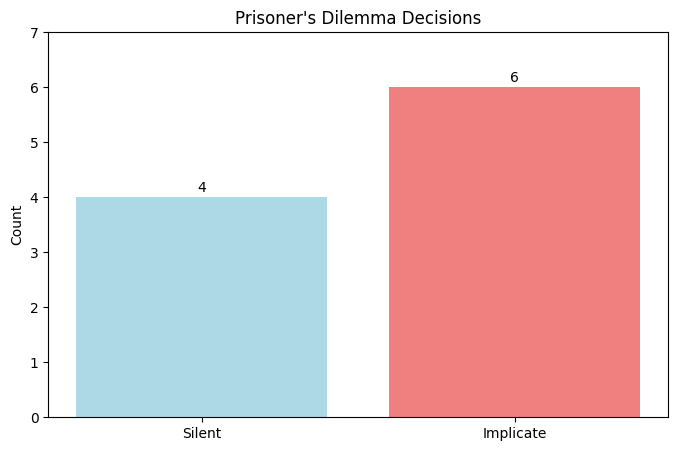

Visualization saved to: experiment_results/prisoner_dilemma_20250421_001227_visualization.png


In [53]:
def create_simple_visualization(valid_results):
    """Create a simple bar chart of decisions"""
    if not valid_results:
        print("No valid results to visualize")
        return

    # Count decisions
    silent_count = sum(1 for r in valid_results if r["response"])
    implicate_count = len(valid_results) - silent_count

    # Create bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(['Silent', 'Implicate'], [silent_count, implicate_count],
            color=['lightblue', 'lightcoral'])

    # Add count labels on bars
    for i, count in enumerate([silent_count, implicate_count]):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.title('Prisoner\'s Dilemma Decisions')
    plt.ylabel('Count')
    plt.ylim(0, max(silent_count, implicate_count) + 1)  # Add some space for labels

    # Save and show
    viz_output_file = f"{output_prefix}_visualization.png"
    plt.savefig(viz_output_file)
    plt.show()
    print(f"Visualization saved to: {viz_output_file}")

# Create visualization (if valid_results exist)
if valid_results:
    create_simple_visualization(valid_results)
else:
    print("Skipping visualization due to lack of valid results.")

In [55]:
def create_final_output(valid_results):
    """Create the final expected output format including metadata"""
    final_output = []

    for result in valid_results:
        # Create the output item including metadata
        output_item = {
            "response_text": result.get("response_text", ""),
            "response": result.get("response", None),
            "decision": result.get("decision", None),
            "reason": result.get("reason", ""),
            "iteration": result.get("iteration", None),
            "response_time": result.get("response_time", None),
            "timestamp": result.get("timestamp", None)
        }
        final_output.append(output_item)

    # Save to file
    final_output_file = "prisoner_dilemma_final_output_with_metadata.json"
    with open(final_output_file, "w") as f:
        json.dump(final_output, indent=2, fp=f)

    print(f"Final output saved to: {final_output_file}")
    print("\nSample of final output format:")
    if final_output:
        print(json.dumps(final_output[0], indent=2))
    else:
        print("No valid results to create final output from.")

    return final_output

# Create final output using valid_results
final_output = create_final_output(valid_results)

Final output saved to: prisoner_dilemma_final_output_with_metadata.json

Sample of final output format:
{
  "response_text": "Silent\n\nI choose to remain silent because, in this scenario, my partner's actions are not something I can control. If they implicate me, it's out of their own self-interest and not a result of my actions. By staying silent, I'm taking advantage of the situation where if we both stay quiet, we both get a lesser sentence. Implicating them would put me in a worse position, as I'd be penalized more severely than they are rewarded by going free.",
  "response": true,
  "decision": "Silent",
  "reason": "I choose to remain silent because, in this scenario, my partner's actions are not something I can control. If they implicate me, it's out of their own self-interest and not a result of my actions. By staying silent, I'm taking advantage of the situation where if we both stay quiet, we both get a lesser sentence. Implicating them would put me in a worse position, as 